# OCR process flow

In [1]:
import matplotlib.pyplot as plt
%matplotlib notebook

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import random
from sklearn.datasets import make_blobs
from PIL import Image

(74, 220)


<IPython.core.display.Javascript object>


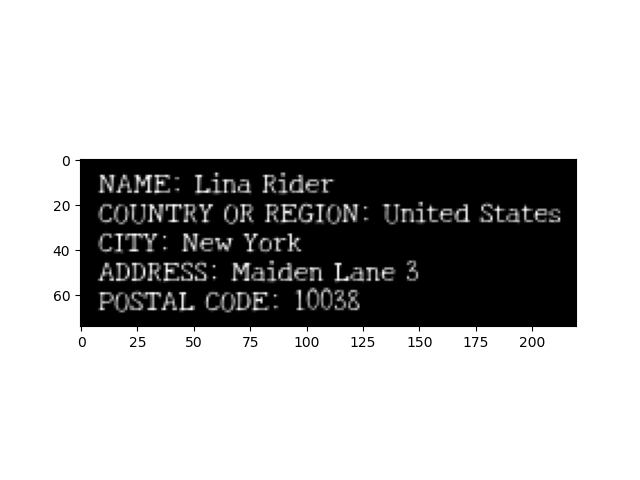

In [2]:
img = np.asarray(Image.open('../imgs/experiments/segmentation/etiqueta6.png'), dtype=np.uint32)
#img = np.asarray(Image.open('../imgs/chars/labels/etiqueta6.png'), dtype=np.uint32)

img = np.mean(img, axis=2)
img = 255 - img
print(img.shape)
plt.figure()
plt.imshow(img, cmap="gray")

## Light correction

### Method 1: Opening residue

<IPython.core.display.Javascript object>


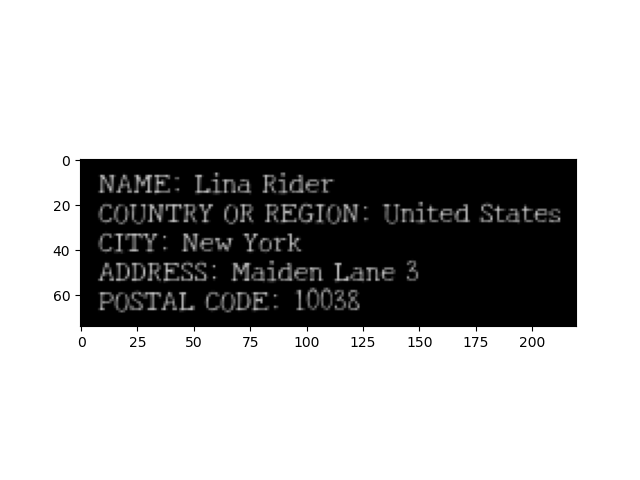

In [14]:
import Mathematical_Morphology as morpho

img_op_res = morpho.openingResidue(img, 20, 20)

plt.figure()
plt.imshow(img_op_res, cmap='gray', vmin=0, vmax=255)

#### Binarization:

##### Manually setting threshold:

<IPython.core.display.Javascript object>


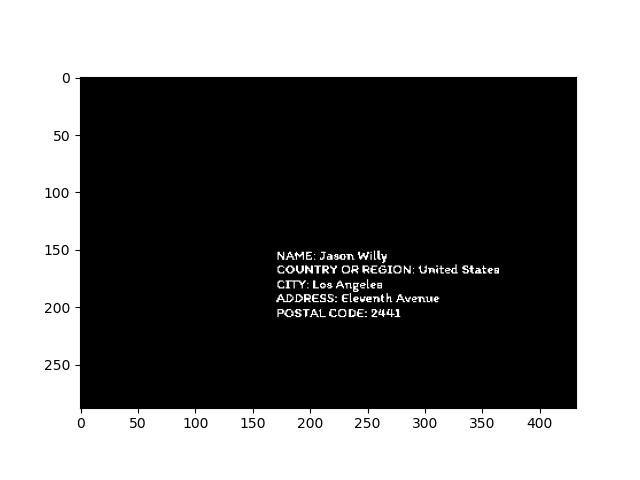

In [56]:
img_op_res_bin = img_op_res.copy()
img_op_res_bin[img_op_res_bin <= 65] = 0
img_op_res_bin[img_op_res_bin > 65] = 1

plt.figure()
plt.imshow(img_op_res_bin, cmap='gray', vmin=0, vmax=1)

The threshold will be different depending on the type of the letter font, so we use Mean shift to determine the local maximums of the probability density to be able to binarize keeping only the center of the letters.


##### Using Mean shift to segment the text

In [5]:
import MeanShift as MeanShift

X = img.reshape(-1, 1)
print(X.shape)
finalPoints = MeanShift.MeanShift(X, h=20)

(42600, 1)


In [6]:
clusterColors = {}
colores = []
cm = list(map(str, finalPoints))
quantities = {}

for c in cm:
    if c in clusterColors:
        colores.append(clusterColors[c])
        quantities[c] = quantities[c] + 1
    else:
        newColor = np.random.default_rng().uniform(0,255,3).astype(np.uint8)
        clusterColors[c] = newColor
        quantities[c] = 1
        colores.append(clusterColors[c])
        
        
print("Number of clusters generated: " + str(len(clusterColors)))

Number of clusters generated: 14


In [57]:
maxQ = 0
maxQVal = 0
minQ = 250
minQVal = []

imagen_clusterizada = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint32)
asignaciones2 = np.round(finalPoints.reshape(img.shape[0], img.shape[1]), 5)

for k,v in clusterColors.items():
    imagen_clusterizada[asignaciones2==round(float(k[1:-1]), 5)] = v
    
    if quantities[k] > maxQ:
        maxQ = quantities[k]
        maxQVal = v
        
    if quantities[k] < minQ:
        minQVal.append(v)
    
plt.figure()
plt.title("Mean shift result")
plt.imshow(imagen_clusterizada)
plt.show()

ValueError: cannot reshape array of size 42600 into shape (288,432)

<IPython.core.display.Javascript object>


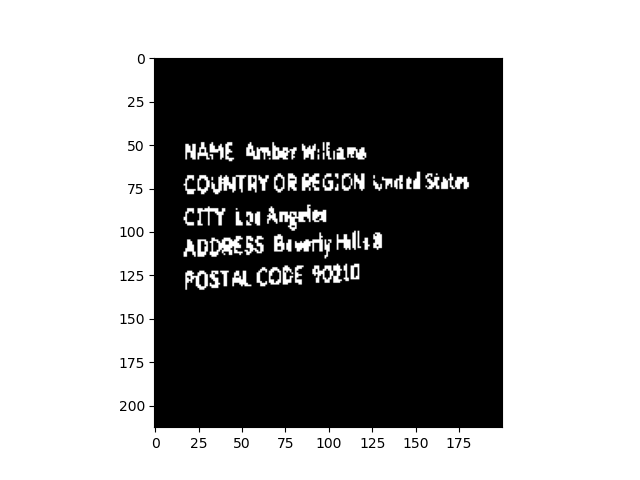

In [8]:
image_letters = np.where(imagen_clusterizada!=maxQVal, 1, 0)

for mv in minQVal:
    image_letters = np.where(imagen_clusterizada!=mv, image_letters, 0)

image_letters = image_letters[:, :, 0]
plt.figure()
plt.imshow(image_letters, cmap='gray', vmin=0, vmax=1)
plt.show()

### Method 2: Niblack method

<IPython.core.display.Javascript object>


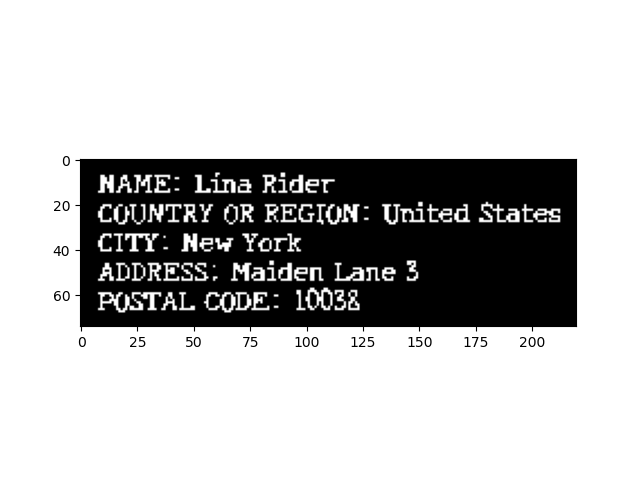

In [3]:
import Niblack as niblack

image_letters = niblack.NiblackBinarization(img, 15, 15, 0.3)

plt.figure()
plt.imshow(image_letters, cmap='gray', vmin=0, vmax=1)
plt.show()

## Labeling:

In [4]:
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

## To see the background always as black
colormap = plt.get_cmap('rainbow', 100)
newcolors = colormap(np.linspace(0, 1, 500))
black = np.array([0, 0, 0, 1])
np.random.shuffle(newcolors)
newcolors[0, :] = black
newcolormap = ListedColormap(newcolors)

<IPython.core.display.Javascript object>


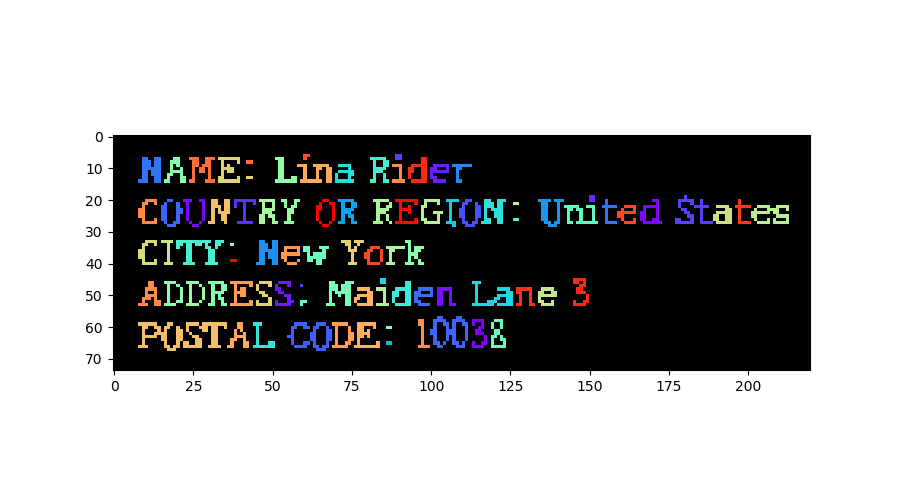

In [5]:
import LabelingRegions as LabelingRegions

[im_out, eq] = LabelingRegions.LabelingRegionsC8(image_letters)

plt.figure(figsize=(9,5))
plt.imshow(im_out, cmap=newcolormap)
plt.show()

In [7]:
print(eq)

{11: [18], 4: [3], 7: [6], 13: [8], 16: [21], 22: [8], 24: [9], 15: [14], 17: [25], 27: [51], 50: [61], 52: [51], 37: [36], 57: [41], 46: [45], 64: [63], 33: [32], 62: [66], 67: [28], 34: [73], 68: [41], 65: [42], 59: [58], 70: [60], 51: [71], 66: [51], 72: [63], 54: [29], 31: [30], 55: [44], 48: [47], 77: [76], 79: [78], 81: [80], 86: [90], 89: [82], 90: [85], 91: [74], 93: [84], 105: [111], 108: [100], 104: [103], 109: [117], 114: [118], 118: [123], 119: [100], 101: [120], 102: [121], 110: [126], 123: [106], 124: [116], 95: [125], 135: [134], 128: [127], 133: [132], 144: [141], 139: [146], 134: [142], 145: [137], 146: [138], 147: [141], 130: [149], 142: [132]}


In [8]:
unique, counts = np.unique(im_out.reshape(-1), return_counts=True)
labels = np.asarray((unique, counts)).T

<IPython.core.display.Javascript object>


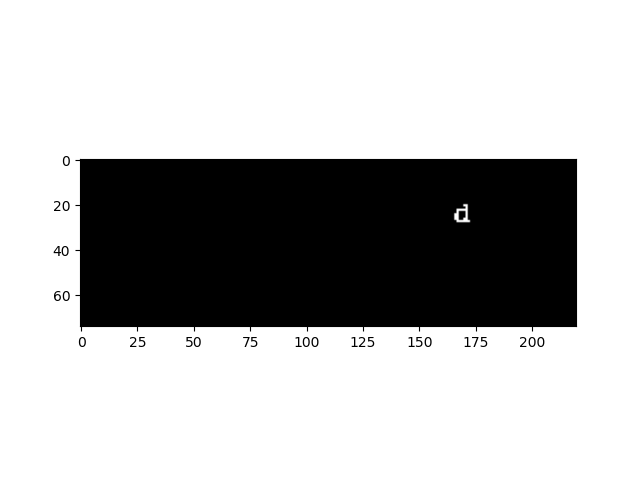

In [13]:
letter1 = np.where(im_out==61, 1, 0)
plt.figure()
plt.imshow(letter1, cmap="gray", vmin=0, vmax=1)
plt.show()

In [12]:
labeled_letters = []
for region_number, quantity in labels:
    if(region_number!=0):
        if(quantity > 25):
            letter1 = np.where(im_out==region_number, 1, 0)
            labeled_letters.append(letter1)